In [6]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def tfgaussmf(tensor_x, tensor_mean, tensor_sigma):
    """
    Calculate Gaussian fuzzy membership function
    tensor_x: input variable
    tensor_mean: parameter 'mean' of functions
    tensor_sigma: parameter 'sigma' of functions
    tensor_x, tensor_mean, tensor_sigma must have the same shape
    """
    num = -tf.square(tf.subtract(tensor_x, tensor_mean))
    den = 2*tf.square(tensor_sigma)
    return tf.exp(tf.divide(num, den))

In [4]:
def tfcartesian_prod(tensor1, tensor2):
    """
    Calculate Cartesian product of two tensor 1&2, shaped (?, n)
    Return tensor shaped (?, n, n, 2)
    (n, n) means two vectors with shape (n) with have (nxn) elements in Cartesian product
    """
    expand1 = tf.expand_dims(tf.tile(tf.expand_dims(tensor1, 2), [1,1,tf.shape(tensor2)[1]]),3)
    expand2 = tf.expand_dims(tf.tile(tf.expand_dims(tensor2, 1), [1,tf.shape(tensor1)[1],1]),3)
    
    return tf.concat([expand1, expand2], axis=3)

In [5]:
n_inputs = 4
n_mfs = 3

In [51]:
class ANFIS(object):
    
    def __init__(self, n_inputs, n_mfs, learning_rate=1e-2):
        """
        Initialization method
        :param n_inputs: number of input variables, (dimmension of input)
        :param n_mfs: number of membership functions per variables
        :param learning_rate: learning rate
        """
        
        self.n = n_inputs  # input dimmension
        self.m = n_mfs     # membership functions per dimmension
                           # number of possible rules = n * m
        self.learning_rate = learning_rate
        
        # node for input
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs), name='input')
        # node for desired output
        self.targets = tf.placeholder(tf.float32, shape=None, name='target')
        
        # transform input
        int_t = tf.reshape(self.inputs, (-1, n_inputs, 1))
        int_t = tf.reshape(tf.tile(int_t, (1,1,n_mfs)), (-1, n_inputs, n_mfs))
        
        # initialize means
        mu = tf.get_variable(
            name='mu'+str(int(time.time())), 
            shape=[n_inputs,n_mfs],
            initializer=tf.random_normal_initializer(0.1, 1)
        )
        
        # initilize sigmas
        sigma = tf.get_variable(
            name='sigma'+str(int(time.time())), 
            shape=[n_inputs, n_mfs],
            initializer=tf.random_normal_initializer(0.1, 1)
        )
        
        # layer 1: Fuzzification layer
        self.layer1 = tfgaussmf(tensor_x=int_t, tensor_mean=mu, tensor_sigma=sigma)
        
        # layer 2: Rule operation layer
        l1s = [self.layer1[:,i,:] for i in range(n_inputs)]
        layer2 = l1s[0]
        for i in range(1, n_inputs):
            layer2 = tfcartesian_prod(layer2, l1s[i])
            layer2 = tf.reduce_prod(layer2, axis=-1)
            layer2 = tf.reshape(layer2, (-1, n_mfs**(i+1)))
            
        # layer 3 - normalization (~w_r)
        layer3 = tf.divide(layer2,tf.reduce_sum(layer2, axis=-1, keepdims=True))
        
        # layer 4 - consequent layer
        # initialise f
        center = tf.get_variable(
                    name='center'+str(int(time.time())), 
                    shape=[n_mfs**n_inputs],
                    initializer=tf.random_normal_initializer(0.1, 1)
                )
        self.params = [mu, sigma, center]
        
        layer4 = tf.multiply(layer3, center)

        # layer 5 - predited value
        self.out = tf.reduce_sum(layer4, axis=-1)
        
        # Loss - objective function
        self.loss = tf.losses.huber_loss(self.targets, self.out)
        
        # Optimizer
        self.optimize = tf.train.AdamOptimizer(
            learning_rate=learning_rate
        ).minimize(self.loss)
        
        # Variable initializer
        self.init_variables = tf.global_variables_initializer()
        
    def fit(self, sess, x, targets):
        """
        Train model with input x and true value y
        sess: TensorFlow session
        Return loss and predicted values
        """
        yp, l, _ = sess.run(
            [self.out, self.loss, self.optimize], 
            feed_dict={self.inputs: x, self.targets: targets}
        )
        return l, yp
    
    def infer(self, sess, x, targets=None):
        """
        Inference process (forward pass)
        """
        if targets is None:
            # if there is no target, return predicted value
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            # else targets are defined, return predicted value and loss value
            return sess.run(
                [self.out, self.loss], 
                feed_dict={self.inputs: x, self.targets: targets}
            )
    
    def plotmfs(self, sess):
        """
        Plot membership function
        """
        xx = np.linspace(start=-10, stop=10, num=2001)
        xx = np.stack([xx for i in range(self.n)]).T
        
        layer1 = sess.run(self.layer1, {self.inputs: xx})
        
        params = sess.run(self.params)
        mu = params[0]
        sigma = params[1]
        
        for i in range(self.n):
            plt.figure(figsize=(10,7))
            for j in range(self.m):
                fun = layer1[:, i, j]
                plt.scatter(x=xx[:,0], y=fun, s=1, 
                            label="MF%d\nm: %.3f, s: %.3f"%(j+1, mu[i,j], sigma[i,j]))
                plt.title('Membership functions of %d-th variable' % (i+1))
                plt.grid(True)
                plt.legend()
                plt.xlabel('x')
                plt.ylabel('Membership function')

In [13]:
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x


# Generate dataset
D = n_inputs  # number of regressors
T = 1  # delay
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - 3*T],mg_series[t - 2*T],mg_series[t - T], mg_series[t]]
    ## [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]
    
trnData = data[:lbls.size - round(lbls.size * 0.3), :]
trnLbls = lbls[:lbls.size - round(lbls.size * 0.3)]
chkData = data[lbls.size - round(lbls.size * 0.3):, :]
chkLbls = lbls[lbls.size - round(lbls.size * 0.3):]

In [62]:
fis = ANFIS(n_inputs=n_inputs, n_mfs=3)

Train cost after epoch 0: 0.433807
Train cost after epoch 10: 0.267523
Train cost after epoch 20: 0.128239
Train cost after epoch 30: 0.060827
Train cost after epoch 40: 0.036061
Train cost after epoch 50: 0.024079
Train cost after epoch 60: 0.015022
Train cost after epoch 70: 0.010439
Train cost after epoch 80: 0.007517
Train cost after epoch 90: 0.005771
Train cost after epoch 100: 0.004661
Train cost after epoch 110: 0.004060
Train cost after epoch 120: 0.003744
Train cost after epoch 130: 0.003551
Train cost after epoch 140: 0.003405
Train cost after epoch 150: 0.003279
Train cost after epoch 160: 0.003167
Train cost after epoch 170: 0.003061
Train cost after epoch 180: 0.002956
Train cost after epoch 190: 0.002852
Elapsed time: 6.773854
Validation loss: 0.002800


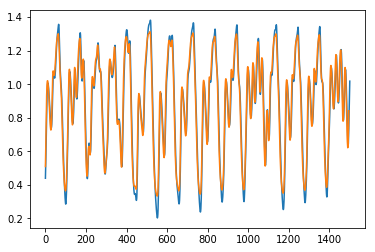

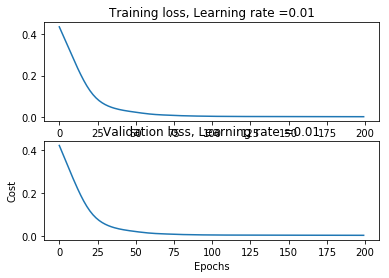

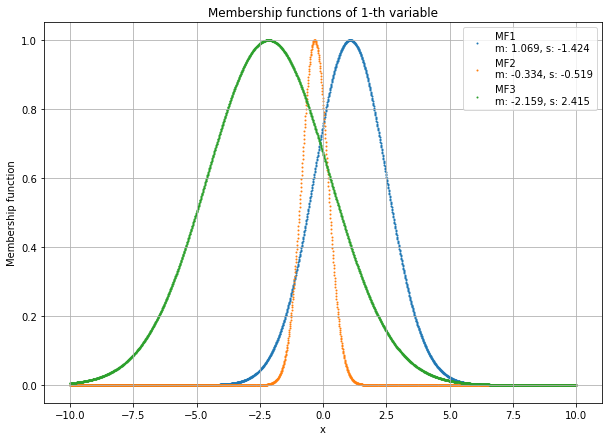

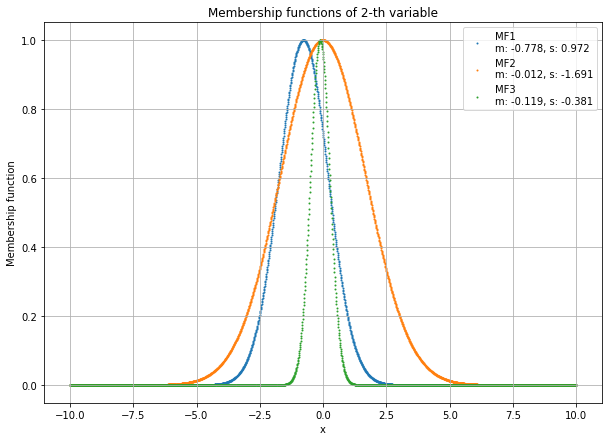

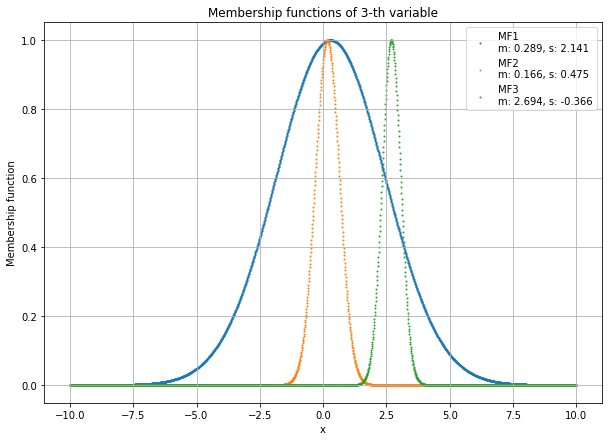

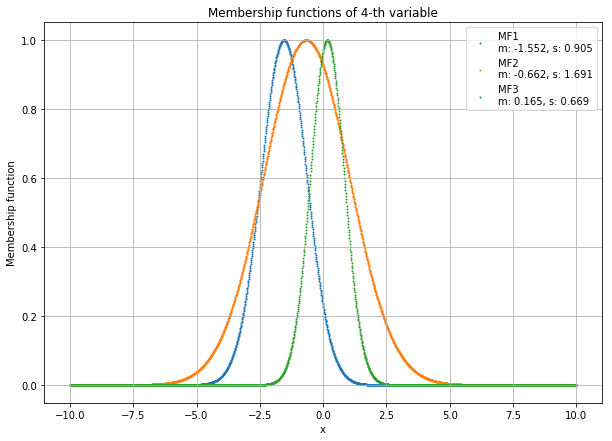

[-0.5022928   1.0574124   1.5236245   0.670342   -1.3652368   0.02743141
  0.7555204  -1.2206212   0.1737502   0.35113695  1.1521256   1.5828266
 -0.92864716 -0.31011882 -0.51985824 -1.5610334  -0.87988114 -1.1084092
  1.5266569   0.33843812  0.2353466  -0.77335995  0.220063   -0.81928
 -0.4870414  -0.42516693 -0.4439121   0.84755886 -0.7197629   1.5801892
 -0.15136415 -1.0681003  -0.50936055  0.4393701   0.66637856  1.4538713
  1.3735476   1.3616692   0.6446472  -1.0348923  -0.19900627 -1.0760742
  0.07954136  0.43179297  2.352441    0.30686736 -0.7204837   1.9725366
 -0.6669647   0.3438767  -1.0436941   0.9999025   1.6773      1.7099813
  0.3832743  -0.01021255  0.18817273  0.29731658 -0.2194712   1.3491967
  0.2105934   0.87736976 -0.15530902  0.15066558  2.7084558   0.04493778
  1.6531578   0.7941763   0.64603347 -0.8154842   0.70138025 -0.01746313
  0.1062931   0.5979791  -0.11627316 -1.1671817   1.2589927   0.3611626
 -0.80672896  0.41891685 -1.1581043 ]


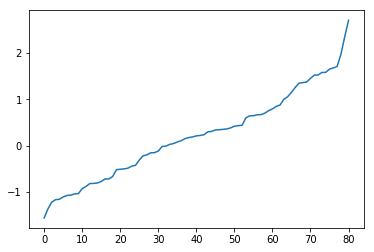

In [63]:
# Training
num_epochs = 200

# Initialize session to make computations on the Tensorflow graph
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis.fit(sess, trnData, trnLbls)
        # Evaluate on validation set
        val_pred, val_loss = fis.infer(sess, chkData, chkLbls)
        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(trn_pred, 1), np.expand_dims(val_pred, 1)))
            plt.figure(1)
            plt.plot(mg_series)
            plt.plot(pred)
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(fis.learning_rate))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(fis.learning_rate))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis.plotmfs(sess)
    plt.show()
    
    # Consequent values
    y = sess.run(fis.params)[2]
    print(y)
    plt.figure()
    plt.plot(sorted(y))